In [ ]:
import sys
sys.path.append("./src/model")
from FLUID import *
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
import math
from tqdm import tqdm
import hydra
from omegaconf import DictConfig, OmegaConf

In [2]:
def samplepoints2graphs(device, points, radius):
    index_arr = np.arange(len(points))
    points, reordered_index, npts = MultiResGraph(points=points.numpy(), index=index_arr, levels=3, pc2gfactor=3.0, g2gfactor=4.0, method='random')
    nodeidx = np.arange(npts[0])
    pc2g_edges = PointCloudToGraph(points, nodeidx, radius=radius)
    g2g_edges = GraphToGraphEdges(points, npts)
    g2pc_edges = np.flip(pc2g_edges, axis=-1)
    g2pc_edges = g2pc_edges.copy()
    
    points = torch.from_numpy(points)
    pc2g_edges = torch.from_numpy(pc2g_edges)
    g2g_edges = torch.from_numpy(g2g_edges)
    g2pc_edges = torch.from_numpy(g2pc_edges)

    # Encoder
    senders = pc2g_edges[...,0]
    receivers = pc2g_edges[...,1]
    relative_mesh_pos = points[senders] - points[receivers]
    pc2g_edge_features = torch.cat([relative_mesh_pos / radius, torch.norm(relative_mesh_pos, dim=-1, keepdim=True) / radius], dim=-1)

    # DSE
    g_points = points[:npts[0]][None,...].to(device)
    transform = VFT(g_points[:,:,0], g_points[:,:,1], 16)

    # Multi-Res Graph
    senders = g2g_edges[...,0]
    receivers = g2g_edges[...,1]
    relative_mesh_pos = points[senders] - points[receivers]
    g2g_edge_features = torch.cat([relative_mesh_pos, torch.norm(relative_mesh_pos, dim=-1, keepdim=True)], dim=-1)

    # Decoder
    senders = g2pc_edges[...,0]
    receivers = g2pc_edges[...,1]
    relative_mesh_pos = points[senders] - points[receivers]
    g2pc_edge_features = torch.cat([relative_mesh_pos / radius, torch.norm(relative_mesh_pos, dim=-1, keepdim=True) / radius], dim=-1)

    # Data Preparation
    pc2g_edges = pc2g_edges.to(device)
    g2g_edges = g2g_edges.to(device)
    g2pc_edges = g2pc_edges.to(device)

    pc2g_edge_features = pc2g_edge_features[None,...]
    pc2g_edge_features = pc2g_edge_features.to(device)

    g2g_edge_features = g2g_edge_features[None,...]
    g2g_edge_features = g2g_edge_features.to(device)

    g2pc_edge_features = g2pc_edge_features[None,...]
    g2pc_edge_features = g2pc_edge_features.to(device)

    pc2g = {}
    g2g = {}
    g2pc = {}
    pc2g['edge_idx'] = pc2g_edges
    pc2g['edge_features'] = pc2g_edge_features

    g2g['edge_idx'] = g2g_edges
    g2g['edge_features'] = g2g_edge_features
    g2g['node_features'] = None

    g2pc['edge_idx'] = g2pc_edges
    g2pc['edge_features'] = g2pc_edge_features
    g2pc['node_features'] = None

    return points, reordered_index, pc2g, g2g, transform, g2pc

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
device = pytorch_device_config()
input_dim_node=1
input_dim_edge=3
out_features = 1

coords = np.load('data/smoke/testing_data/xy.npy')

# The domain is defined on [0, 100] x [0, 100]
coords = (coords / 100)
radius = max_closest_dist(coords) * 3.0

pos_t = torch.from_numpy(coords.astype(np.float32))
num_nodes = pos_t.shape[0]
grid_sample_points, reordered_index, grid_pc2g, grid_g2g, grid_transform, grid_g2pc = samplepoints2graphs(device, pos_t, radius)

Running on the GPU


In [ ]:
model = FLUID(input_dim_edge=input_dim_edge, input_dim_node=input_dim_node, num_modes=16, hidden_dim=128, output_dim_node=out_features)
model.load_state_dict(torch.load('src/smoke/FLUID/weights/FLUID_500.pth', weights_only=True))
model.to(device)

FLUID(
  (encoder): Encoder(
    (embed_edge_fn): FeedForwardBlock(
      (layers): ModuleList(
        (0): Linear(in_features=3, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
      )
      (layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (embed_node_fn): FeedForwardBlock(
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
      )
      (layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (process_network): GraphNetwork(
      (update_edge_fn): FeedForwardBlock(
        (layers): ModuleList(
          (0): Linear(in_features=384, out_features=128, bias=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
        )
        (layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (update_node_fn): FeedForwardBlock(
        (layers): Modul

In [ ]:
lf_fname = 'data/smoke/testing_data/low_fidelity_1.npy'
hf_fname = 'data/smoke/testing_data/high_fidelity_1.npy'
lf_s = torch.from_numpy(np.load(lf_fname)[81:].astype(np.float32))
hf_s = torch.from_numpy(np.load(hf_fname)[81:].astype(np.float32))
lf_s = ((lf_s - lprange['smoke'][0]) / (lprange['smoke'][1] - lprange['smoke'][0]))
hf_s = ((hf_s - hprange['smoke'][0]) / (hprange['smoke'][1] - hprange['smoke'][0]))
all_lf_smoke = lf_s[..., reordered_index][...,None].to(device)
all_hf_smoke = hf_s[..., reordered_index][...,None].to(device)

In [6]:
def draw_smoke(data, mask, masked_samples, reordered_idx):
    fullres_arr = np.full(mask.shape[0]*mask.shape[1], np.nan)
    fullres_arr[masked_samples[reordered_idx]] = data
    plt.imshow(fullres_arr.reshape(mask.shape[0], mask.shape[1]).T, origin='lower', cmap='PRGn', vmin=0.0, vmax=1.0)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

In [ ]:
mask = np.load('data/smoke/testing_data/mask.npy')
mask_flatten = mask.flatten()
selected_samples = np.arange(len(mask_flatten))[mask_flatten]

model.eval()
with torch.no_grad():
    lf_feats = all_lf_smoke[20][None,...]
    hf_feats = all_hf_smoke[20][None,...]
    grid_pc2g['node_features'] = lf_feats
    model_output = model(grid_pc2g, grid_g2g, grid_transform, grid_g2pc)
    model_output, hf_feats = torch.squeeze(model_output), torch.squeeze(hf_feats)

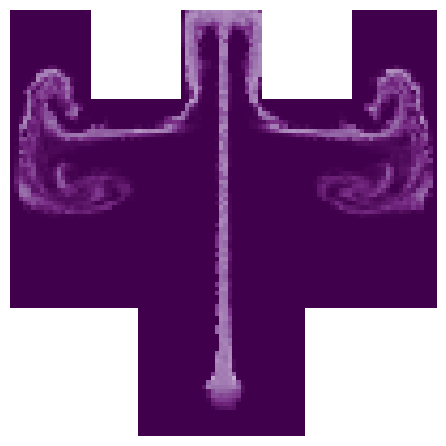

In [8]:
model_output = model_output.cpu().numpy()
draw_smoke(model_output, mask, selected_samples, reordered_index)

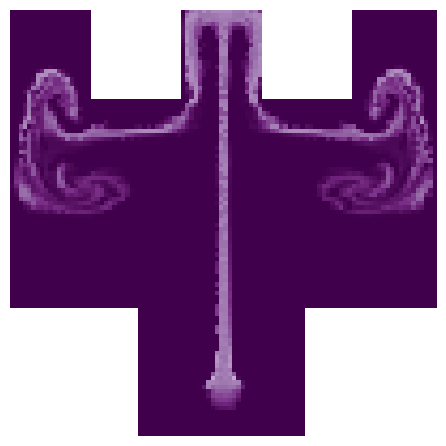

In [9]:
ground_truth = hf_feats.cpu().numpy()
draw_smoke(ground_truth, mask, selected_samples, reordered_index)